In [1]:
%matplotlib inline
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from scipy.sparse import hstack

pd.options.display.max_rows = 99999
plt.style.use('dark_background')

In [2]:
# Load data
X_train = pd.read_pickle('./data/training_dat_eng.pkl')
X_test = pd.read_pickle('./data/test_dat_eng.pkl')
print("Train shape ",X_train.shape)
print("Test shape ",X_test.shape)

Train shape  (479186, 6)
Test shape  (119796, 6)


In [3]:
X_train.head()

,useful,date,stars,text,isuseful,length
0,15,2016-07-01,1,Very displeased with the lack of professionali...,1,1231
1,5,2013-02-04,5,I love the group fitness classes! I go 3x/week...,1,255
2,5,2013-07-05,5,Who knew we had this hidden little Italian gem...,1,614
3,12,2012-01-06,4,To be honest I haven't looked at the prices. I...,1,466
4,5,2013-11-10,2,A great menu that isn't the standard cookie-cu...,1,927


In [4]:
X_train.isuseful.mean()

0.5

In [5]:
X_test.head()

,useful,date,stars,text,isuseful,length
239593,5,2014-12-28,5,I had my twins there since they were 18 months...,1,368
239594,6,2014-04-15,4,I test drove a visit to the Phoenix location w...,1,1108
239595,10,2016-01-05,1,TOtal scam company from top to bottom. They wi...,1,387
239596,6,2012-05-14,5,"Bravo, Union!\nPerfection.\n\nI had recently c...",1,2624
239597,7,2013-03-05,1,So incredibly furious with this store. Purchas...,1,736


In [6]:
X_test.isuseful.mean()

0.5

# Helper functions

In [3]:
# look at very bad predictions
def bad_prediction_examples(model,tf_test,
                            n_examples=10,
                           p_bad_thres=.9,
                           high_vote_thres=9,
                           low_vote_thres=0):
    """Generates bad predictions
       where predicted probability is > p_bad_thres
       but the prediction is incorrect
       and if the true number of votes is either <= low_vote_thres
       or >=high_vote_thres
    """
    np.random.seed(42)
    print("very bad predictions")
    for index, row in X_test.iloc[
        np.where(
            np.logical_and(
            np.logical_and(
                model.predict(tf_test) != X_test['isuseful'],
                np.max(model.predict_proba(tf_test),1) > p_bad_thres
                          ),
            X_test['useful'] >= high_vote_thres
            )
        )[0][0:n_examples]
    ][['text','useful']].iterrows():
        print("--------------------------------------------------------------")
        print("True Useful Votes ", row['useful'])
        print("--------------------------------------------------------------")
        print("")
        print(row['text'])
        print("")

    for index, row in X_test.iloc[
        np.where(
            np.logical_and(
            np.logical_and(
                model.predict(tf_test) != X_test['isuseful'],
                np.max(model.predict_proba(tf_test),1) > p_bad_thres
                          ),
            X_test['useful']==0
            )
        )[0][0:n_examples]
    ][['text','useful']].iterrows():
        print("--------------------------------------------------------------")
        print("True Useful Votes ", row['useful'])
        print("--------------------------------------------------------------")
        print("")
        print(row['text'])
        print("")

In [27]:
def plot_LR_important_features(model,
                               vectorizr,
                               num_features=10,
                               size=None
                              ):
    # find the indexes of the highs max value features
    #     for each class
    # argsort finds the feature locations in ascending coef order
    # flip to sort descending
    feature_names = vectorizr.get_feature_names()
    feature_names.append("STAR_RATING")
    feature_names.append("REVIEW_LENGTH")
    
    ind = np.concatenate(
        (np.flip(np.argsort(model.coef_, 1)[:, -num_features:], 1).flatten(),
        np.argsort(model.coef_).flatten()[:num_features])
    )

    features_with_coefs = [feature_names[x] + ": " + "{0:.2f}".format(model.coef_[0,x]) for x in ind]
    coefs = [model.coef_[0,x] for x in ind]
    
        
    plt.figure()
    fig, ax = plt.subplots()
    if size:
        fig.set_size_inches(size[0], size[1])
    else:
        fig.set_size_inches(8, num_features//2)
    y_pos = np.arange(len(coefs))[::-1]
    

    ax.barh(y_pos[:num_features], coefs[:num_features],
            align='center', color='green'
           )
    ax.barh(y_pos[num_features:], coefs[num_features:], color='red')
    ax.set_title('Top '+str(num_features)+' largest and smallest coefs')
    ax.set_xlabel('Change in log odds of being useful\nfrom unit increase in feature')
    ax.spines['left'].set_position('zero')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features_with_coefs)    



In [5]:
def preprocess_text(s):
    ### STUDENT START ###

    # lowercase all
    s = s.lower()
    
    # remove commas within numbers
    s = re.sub(r'(\d)[.](\d)', r'\1\2', s)
    
    # replace long sequences of digits with 99999
    s = re.sub(r'\d{5,}', '99999', s)
    
    # replace digits with DG
    s = re.sub(r'\d{1}','DG', s)
    
    # replace hyperlinks
    s = re.sub(r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)*\/?\S*",
              "HYPERLINK", s)
    s = re.sub(r"(HYPERLINK)+", "HYPERLINK", s)
    
    #replace things like haha with ha
    s = re.sub(r"([a-z]{2,})\1{2,}", r"\1", s)
    #replace any three consecutive, identical letters with two instances of that letter
    s = re.sub(r"([a-z])\1{2,}", r"\1\1", s)
    #creplace any two consecutive, identical consonants at the beginning of a string with one of that consonant
    s = re.sub(r"(^[^aeiou])\1{1,}", r"\1", s)

    return s

def only_lowercase(s):
    ### STUDENT START ###

    # lowercase all
    s = s.lower()

    return s

In [37]:
def run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='l2',
              tfidf=True,
              min_df=1,
              max_df=1.0,
              preprocessor=preprocess_text,
              binary=False,
              num_features=20,
              retrieve_output=False
             ):
    if tfidf:
        tf_vectorizer = TfidfVectorizer(
            ngram_range=ngram_range,
            lowercase=False, #done by processor
            preprocessor=preprocessor,
            stop_words=stop_words,
            min_df=min_df
        )
    else:
        tf_vectorizer = CountVectorizer(
            ngram_range=ngram_range,
            lowercase=False, #done by processor
            preprocessor=preprocessor,
            stop_words=stop_words,
            min_df=min_df,
            binary=binary
        )
    tf_train = tf_vectorizer.fit_transform(X_train['text'])
    tf_test = tf_vectorizer.transform(X_test['text'])
    print("size of vocabulary")
    print(len(tf_vectorizer.vocabulary_))
    print("")

    # add star feature
    tf_train = hstack((tf_train,np.array(X_train['stars'])[:,None]))
    tf_test = hstack((tf_test,np.array(X_test['stars'])[:,None]))

    # add review length (number of characters) feature
    # X_train['length'] = X_train['text'].apply(len)
    # X_test['length'] = X_test['text'].apply(len)
    tf_train = hstack((tf_train,np.array(X_train['length'])[:,None]))
    tf_test = hstack((tf_test,np.array(X_test['length'])[:,None]))
    print("train shape",tf_train.shape)
    print("test shape",tf_test.shape)

    LR = SGDClassifier(random_state=42,
                       loss='log', #logistic regression,
                       tol=1e-4,
                       n_jobs=-1,
                       penalty=penalty,
                      )
    LR.fit(tf_train, X_train['isuseful'])
    target_names=['not_useful','useful']

    print("result on training set:")
    print(classification_report(X_train['isuseful'],
                          LR.predict(tf_train),
                         target_names=target_names))

    print("")
    print("result on test set:")
    print(classification_report(X_test['isuseful'],
                          LR.predict(tf_test),
                         target_names=target_names))
    
    bad_prediction_examples(LR,tf_test=tf_test,
                            n_examples=10,
                            p_bad_thres=.9,
                            high_vote_thres=9,
                            low_vote_thres=0)
    plot_LR_important_features(LR,vectorizr=tf_vectorizer,num_features=num_features)
    if retrieve_output:
        return LR, tf_vectorizer, tf_train, tf_test

In [21]:
tf_vectorizer = CountVectorizer()
tf_train = tf_vectorizer.fit_transform(X_train['text'])
print("size of vocabulary")
print(len(tf_vectorizer.vocabulary_))
print("")
LR = SGDClassifier(random_state=42,
                   loss='log', #logistic regression,
                   tol=1e-4,
                   n_jobs=-1,
                   penalty='l2',
                  )
LR.fit(tf_train, X_train['isuseful'])

size of vocabulary
195497



SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l1', power_t=0.5, random_state=42, shuffle=True,
       tol=0.0001, verbose=0, warm_start=False)

### Not really helpful to look at non-helpful coefs

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


[Text(0,0,'000: 0.0000'),
 Text(0,0,'0000: 0.0000'),
 Text(0,0,'00000: 0.0000'),
 Text(0,0,'000000: 0.0000'),
 Text(0,0,'00000000: 0.0000'),
 Text(0,0,'000000000001777: 0.0000'),
 Text(0,0,'0000000001: 0.0000'),
 Text(0,0,'0000003005: 0.0000'),
 Text(0,0,'00001: 0.0000'),
 Text(0,0,'000067862859: 0.0000'),
 Text(0,0,'000194: 0.0000'),
 Text(0,0,'0002: 0.0000'),
 Text(0,0,'0003: 0.0000'),
 Text(0,0,'0004cd4c1e46626d4526f: 0.0000'),
 Text(0,0,'000ft2: 0.0000'),
 Text(0,0,'000ish: 0.0000'),
 Text(0,0,'000k: 0.0000'),
 Text(0,0,'000km: 0.0000'),
 Text(0,0,'000lbs: 0.0000'),
 Text(0,0,'000membership: 0.0000'),
 Text(0,0,'000miles: 0.0000'),
 Text(0,0,'000points: 0.0000'),
 Text(0,0,'000s: 0.0000'),
 Text(0,0,'000sf: 0.0000'),
 Text(0,0,'000sq: 0.0000'),
 Text(0,0,'000th: 0.0000'),
 Text(0,0,'000they: 0.0000'),
 Text(0,0,'000x: 0.0000'),
 Text(0,0,'001: 0.0000'),
 Text(0,0,'0013026921: 0.0000'),
 Text(0,0,'0015: 0.0000'),
 Text(0,0,'001695: 0.0000'),
 Text(0,0,'001a4bcf6878: 0.0000'),
 Text(

<Figure size 432x288 with 0 Axes>

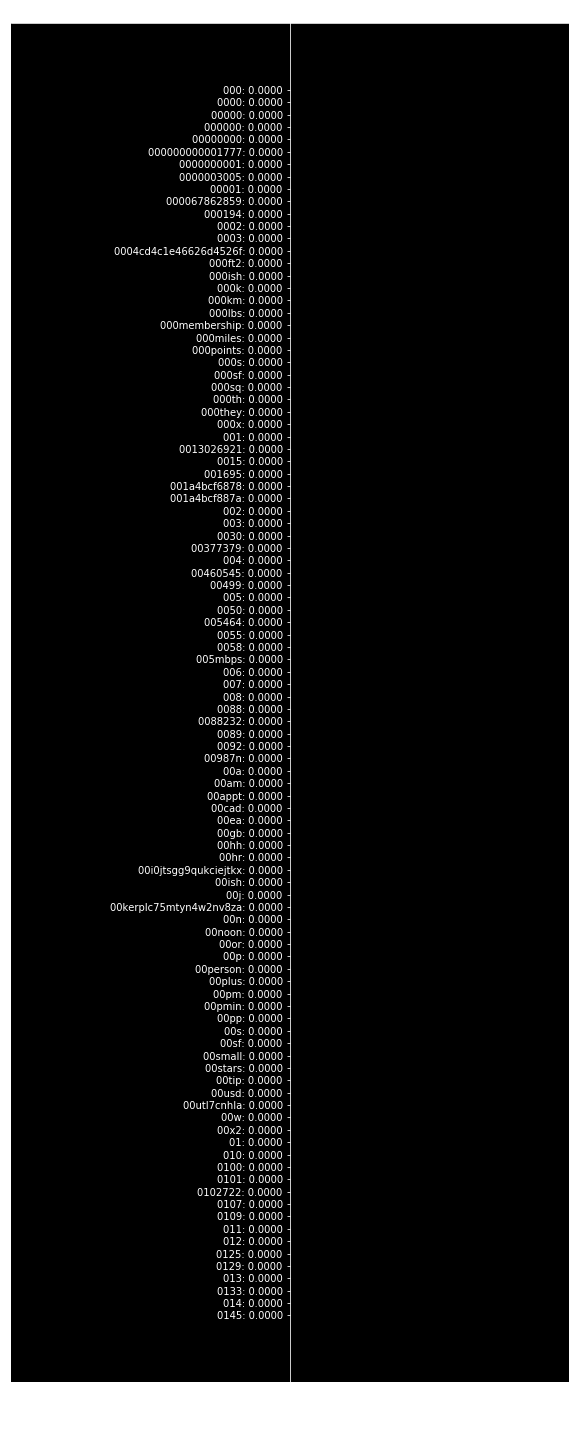

In [22]:
num_features=100
feature_names = tf_vectorizer.get_feature_names()
feature_names.append("STAR_RATING")
feature_names.append("REVIEW_LENGTH")
# also plot features with very small coefs (probably 0)   
ind = np.where(np.abs(LR.coef_) < .001)[1][0:num_features]
print(ind)
features_with_coefs = [feature_names[x] + ": " + "{0:.4f}".format(LR.coef_[0,x]) for x in ind]
coefs = [LR.coef_[0,x] for x in ind]

plt.figure()
fig, ax = plt.subplots()
fig.set_size_inches(10, num_features//4)
y_pos = np.arange(len(coefs))[::-1]


ax.barh(y_pos[:num_features], coefs[:num_features],
        align='center', color='green'
       )
ax.barh(y_pos[num_features:], coefs[num_features:], color='red')
ax.set_title('Top '+str(num_features)+' largest and smallest coefs')
ax.set_xlabel('Change in log odds of being useful\nfrom unit increase in feature')
ax.spines['left'].set_position('zero')
ax.set_yticks(y_pos)
ax.set_yticklabels(features_with_coefs)

In [43]:
pd.Series(np.array(np.sum(tf_train,axis=0)).reshape(-1,)).value_counts()

1            89991
2            23885
3            11635
4             7558
5             5287
6             4002
7             3145
8             2560
9             2241
10            1985
11            1662
12            1522
13            1288
14            1175
15            1129
16             963
17             926
18             853
19             768
20             701
21             677
22             597
24             583
25             557
23             555
26             525
27             494
28             473
29             468
33             378
30             374
32             364
31             360
34             341
35             337
36             314
39             304
38             303
42             285
40             280
37             271
43             257
41             250
45             240
44             237
49             223
46             213
51             210
47             206
48             204
50             197
52             195
54          

# First Baseline Logistic Regression

size of vocabulary
195497

train shape (479186, 195499)
test shape (119796, 195499)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.80      0.56      0.66    239593
     useful       0.66      0.86      0.75    239593

avg / total       0.73      0.71      0.70    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.79      0.56      0.66     59898
     useful       0.66      0.85      0.75     59898

avg / total       0.73      0.71      0.70    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

----------------------------------------------------------

NameError: name 'feature_names' is not defined

<Figure size 432x288 with 0 Axes>

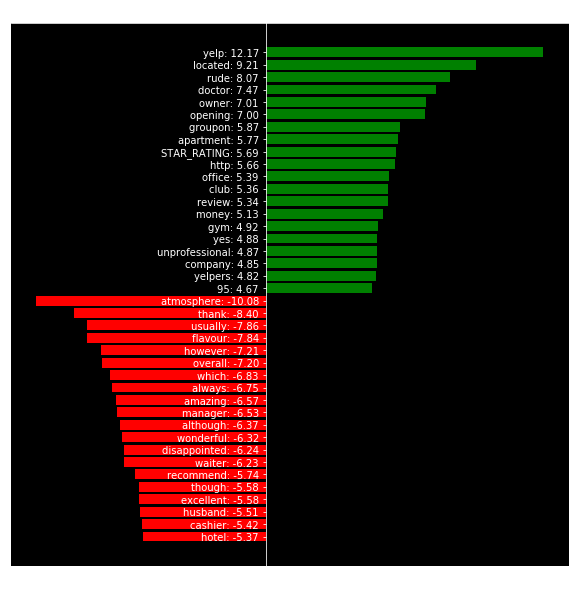

In [19]:
#baseline model
LR = run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='l2',
              tfidf=False,
              min_df=1,
              max_df=1.0,
              preprocessor=only_lowercase,
              binary=False
             )

stop_words = ["a", "about", "above", "above", "across", "after", 
              "afterwards", "again", "against", "all", "almost", 
              "alone", "along", "already", "also","although",
              "always","am","among", "amongst", "amoungst", 
              "amount",  "an", "and", "another", "any","anyhow",
              "anyone","anything","anyway", "anywhere", "are", 
              "around", "as",  "at", "back","be","became", "because",
              "become","becomes", "becoming", "been", "before", 
              "beforehand", "behind", "being", "below", "beside", 
              "besides", "between", "beyond", "bill", "both", 
              "bottom","but", "by", "call", "can", "cannot", "cant",
              "co", "con", "could", "couldnt", "cry", "de", 
              "describe", "detail", "do", "done", "down", "due", 
              "during", "each", "eg", "eight", "either", "eleven","else", 
              "elsewhere", "empty", "enough", "etc", "even", "ever", "every",
              "everyone", "everything", "everywhere", "except", "few", 
              "fifteen", "fify", "fill", "find", "fire", "first", "five",
              "for", "former", "formerly", "forty", "found", "four", "from", 
              "front", "full", "further", "get", "give", "go", "had", "has", 
              "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", 
              "herein", "hereupon", "hers", "herself", "him", "himself", "his", 
              "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", 
              "interest", "into", "is", "it", "its", "itself", "keep", "last", 
              "latter", "latterly", "least", "less", "ltd", "made", "many", "may",
              "me", "meanwhile", "might", "mill", "mine", "more", "moreover",
              "most", "mostly", "move", "much", "must", "my", "myself", "name", 
              "namely", "neither", "never", "nevertheless", "next", "nine", "no", 
              "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", 
              "of", "off", "often", "on", "once", "one", "only", "onto", "or", 
              "other", "others", "otherwise", "our", "ours", "ourselves", "out", 
              "over", "own","part", "per", "perhaps", "please", "put", "rather", 
              "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", 
              "several", "she", "should", "show", "side", "since", "sincere",
              "six", "sixty", "so", "some", "somehow", "someone", "something", 
              "sometime", "sometimes", "somewhere", "still", "such", "system", 
              "take", "ten", "than", "that", "the", "their", "them", "themselves",
              "then", "thence", "there", "thereafter", "thereby", "therefore", 
              "therein", "thereupon", "these", "they", "thickv", "thin", "third", 
              "this", "those", "though", "three", "through", "throughout", "thru", 
              "thus", "to", "together", "too", "top", "toward", "towards", "twelve", 
              "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", 
              "via", "was", "we", "well", "were", "what", "whatever", "when", "whence",
              "whenever", "where", "whereafter", "whereas", "whereby", "wherein", 
              "whereupon", "wherever", "whether", "which", "while", "whither", "who", 
              "whoever", "whole", "whom", "whose", "why", "will", "with", "within", 
              "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves",
              "the"]

# Other models

size of vocabulary
195185

train shape (479186, 195187)
test shape (119796, 195187)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.83      0.44      0.58    239593
     useful       0.62      0.91      0.74    239593

avg / total       0.72      0.67      0.66    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.82      0.44      0.57     59898
     useful       0.62      0.90      0.73     59898

avg / total       0.72      0.67      0.65    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

----------------------------------------------------------

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

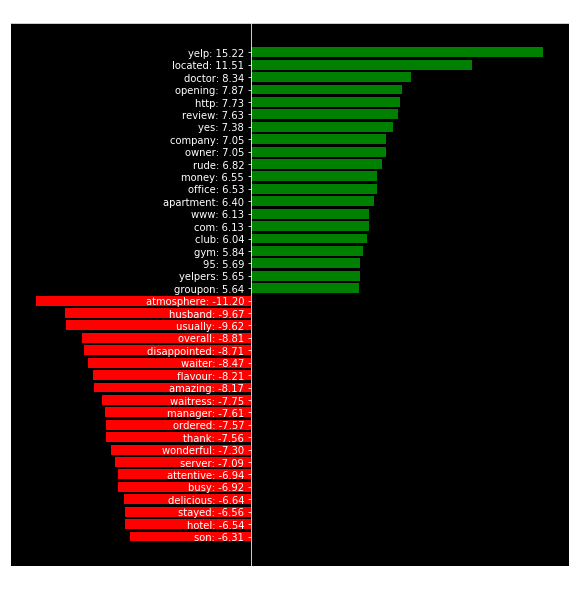

In [10]:
# baseline + stopwords
run_model(stop_words='english',
              ngram_range=(1,1),
              penalty='l2',
              tfidf=False,
              min_df=1,
              max_df=1.0,
              preprocessor=only_lowercase,
              binary=False
             )

size of vocabulary
195497

train shape (479186, 195499)
test shape (119796, 195499)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.87      0.21      0.33    239593
     useful       0.55      0.97      0.70    239593

avg / total       0.71      0.59      0.52    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.87      0.20      0.33     59898
     useful       0.55      0.97      0.70     59898

avg / total       0.71      0.59      0.51    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  24
--------------------------------------------------------------

I see this place has closed. They always had a sign out that read "Opened for Breakfast". But they were never opened for breakfast. I ate there once and had a burger and fries and did not go there again since the food wasn't the greatest.

-------------------------------

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

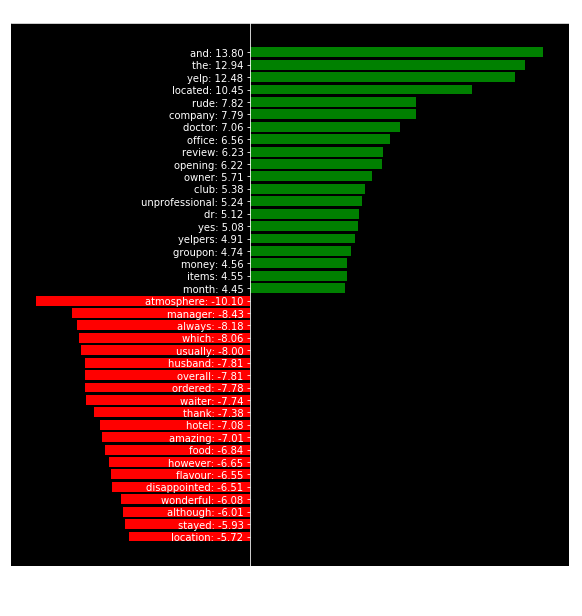

In [12]:
# baseline + binary
run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='l2',
              tfidf=False,
              min_df=1,
              max_df=1.0,
              preprocessor=only_lowercase,
              binary=True
             )

size of vocabulary
195497

train shape (479186, 195499)
test shape (119796, 195499)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.80      0.56      0.66    239593
     useful       0.66      0.86      0.75    239593

avg / total       0.73      0.71      0.70    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.79      0.56      0.66     59898
     useful       0.66      0.85      0.75     59898

avg / total       0.73      0.71      0.70    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

----------------------------------------------------------

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

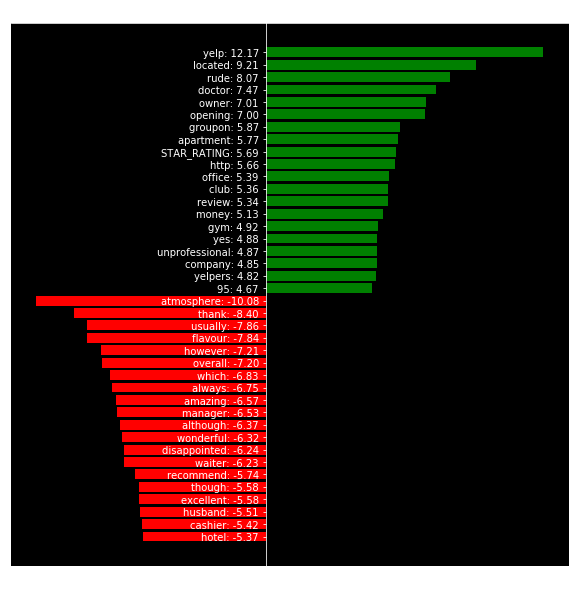

In [14]:
# baseline + max_df
run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='l2',
              tfidf=False,
              min_df=1,
              max_df=0.8,
              preprocessor=only_lowercase,
              binary=False
             )

size of vocabulary
195497

train shape (479186, 195499)
test shape (119796, 195499)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.69      0.69      0.69    239593
     useful       0.69      0.69      0.69    239593

avg / total       0.69      0.69      0.69    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.68      0.69      0.69     59898
     useful       0.69      0.68      0.68     59898

avg / total       0.69      0.69      0.69    119796

very bad predictions


/home/dvl/anaconda3/envs/tf141/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


--------------------------------------------------------------
True Useful Votes  11
--------------------------------------------------------------

Maybe don't treat your loyal customers like crap when your food is mediocre to begin with. I've been coming here out of convenience for years, since there's only one other Thai option in the area. Went to place a phone order today and the woman taking my order was seriously annoyed with me, kept cutting me off as I was trying to tell her which items I would like (a simple lunch order, nothing complicated) and she then hung up on me as I was mid sentence. Rude! I guess you don't need the business, as I ended up getting lunch from Sa Bai instead.

--------------------------------------------------------------
True Useful Votes  10
--------------------------------------------------------------

My daughter and I went here the other day on a play date.  We have been to a lot of indoor play places lately and The Playground is an ok place.

I do

--------------------------------------------------------------
True Useful Votes  0
--------------------------------------------------------------

Pretty average food. The dog patio isn't great, it's down below by the lake and out of sight of the bar and kitchen. This translates to way less than attentive service. We had "brunch" on a slow Sunday and the service was pretty poor. Lovely setting, better concept than execution. If you're looking for good food and service, this is not your place. If you're looking for average food and unreliable service, go for it.

--------------------------------------------------------------
True Useful Votes  0
--------------------------------------------------------------

First time in this spot with my spouse  and loved the classic dinner setting.the staff were super welcoming and friendly. Never got the chance to try the other items on the menu but had the chili cheese fries. As you can tell, everyone including me are suckers for their chili chees

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l1', power_t=0.5, random_state=42, shuffle=True,
       tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

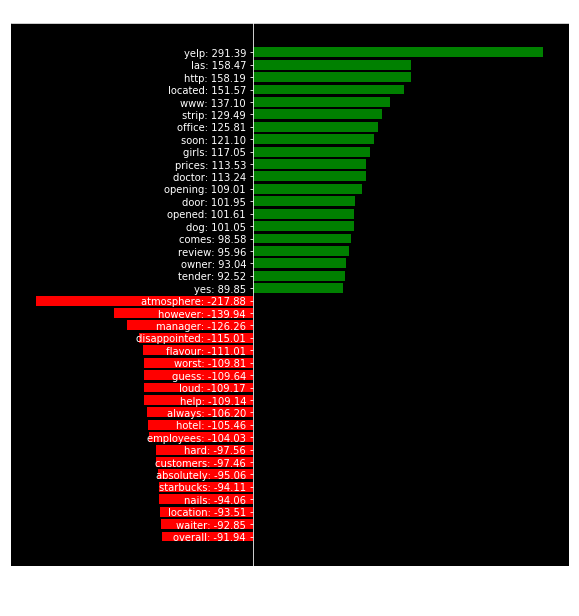

In [15]:
# baseline + l1
run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='l1',
              tfidf=False,
              min_df=1,
              max_df=1.0,
              preprocessor=only_lowercase,
              binary=False
             )

size of vocabulary
195497

train shape (479186, 195499)
test shape (119796, 195499)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.80      0.58      0.67    239593
     useful       0.67      0.85      0.75    239593

avg / total       0.73      0.72      0.71    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.80      0.58      0.67     59898
     useful       0.67      0.85      0.75     59898

avg / total       0.73      0.71      0.71    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

----------------------------------------------------------

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='elasticnet', power_t=0.5, random_state=42,
       shuffle=True, tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

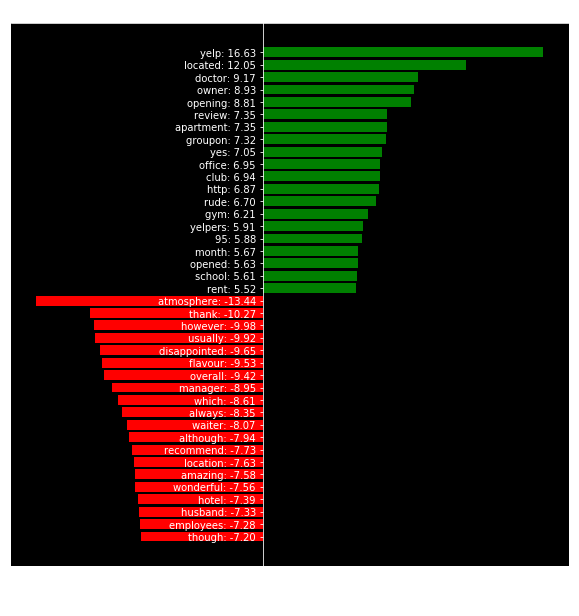

In [24]:
# baseline + elasticnet
run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='elasticnet',
              tfidf=False,
              min_df=1,
              max_df=1.0,
              preprocessor=only_lowercase,
              binary=False
             )

size of vocabulary
175939

train shape (479186, 175941)
test shape (119796, 175941)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.80      0.57      0.67    239593
     useful       0.67      0.86      0.75    239593

avg / total       0.73      0.71      0.71    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.80      0.57      0.67     59898
     useful       0.67      0.85      0.75     59898

avg / total       0.73      0.71      0.71    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

----------------------------------------------------------

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

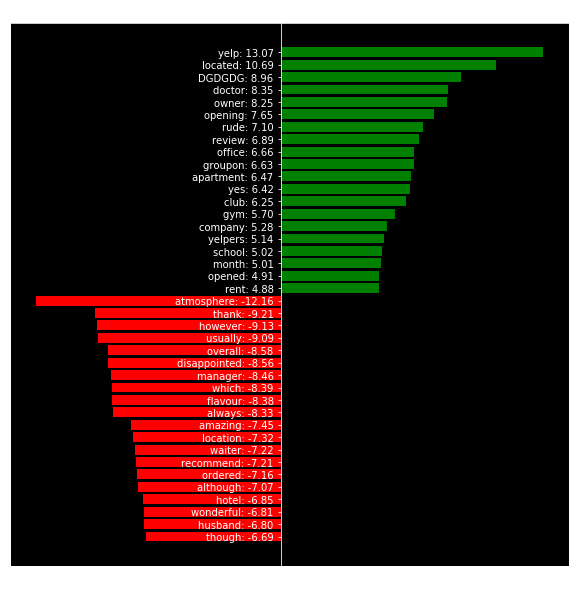

In [16]:
# baseline + preprocess
run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='l2',
              tfidf=False,
              min_df=1,
              max_df=1.0,
              preprocessor=preprocess_text,
              binary=False
             )

size of vocabulary
195497

train shape (479186, 195499)
test shape (119796, 195499)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.83      0.29      0.43    239593
     useful       0.57      0.94      0.71    239593

avg / total       0.70      0.61      0.57    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.83      0.29      0.43     59898
     useful       0.57      0.94      0.71     59898

avg / total       0.70      0.61      0.57    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

----------------------------------------------------------

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

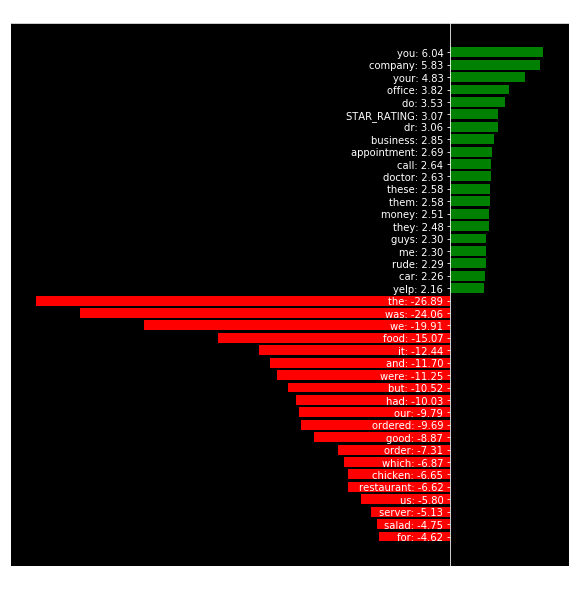

In [17]:
# baseline -> tfidf
run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='l2',
              tfidf=True,
              min_df=1,
              max_df=1.0,
              preprocessor=only_lowercase,
              binary=False
             )

size of vocabulary
195497

train shape (479186, 195499)
test shape (119796, 195499)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.69      0.70      0.69    239593
     useful       0.69      0.69      0.69    239593

avg / total       0.69      0.69      0.69    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.68      0.69      0.69     59898
     useful       0.69      0.68      0.68     59898

avg / total       0.69      0.69      0.69    119796

very bad predictions


/home/dvl/anaconda3/envs/tf141/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


--------------------------------------------------------------
True Useful Votes  11
--------------------------------------------------------------

Maybe don't treat your loyal customers like crap when your food is mediocre to begin with. I've been coming here out of convenience for years, since there's only one other Thai option in the area. Went to place a phone order today and the woman taking my order was seriously annoyed with me, kept cutting me off as I was trying to tell her which items I would like (a simple lunch order, nothing complicated) and she then hung up on me as I was mid sentence. Rude! I guess you don't need the business, as I ended up getting lunch from Sa Bai instead.

--------------------------------------------------------------
True Useful Votes  10
--------------------------------------------------------------

My daughter and I went here the other day on a play date.  We have been to a lot of indoor play places lately and The Playground is an ok place.

I do

--------------------------------------------------------------
True Useful Votes  0
--------------------------------------------------------------

Pretty average food. The dog patio isn't great, it's down below by the lake and out of sight of the bar and kitchen. This translates to way less than attentive service. We had "brunch" on a slow Sunday and the service was pretty poor. Lovely setting, better concept than execution. If you're looking for good food and service, this is not your place. If you're looking for average food and unreliable service, go for it.

--------------------------------------------------------------
True Useful Votes  0
--------------------------------------------------------------

I went in on Nov. 25th to get a full set (acrylic with gel lacquer,) I usually go to Polished but I waited last minute before an event I had coming up and need to go in after normal salon business hours. For a full set I spent 75$ (with gratuity,) and two weeks later when I was rea

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='none', power_t=0.5, random_state=42,
       shuffle=True, tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

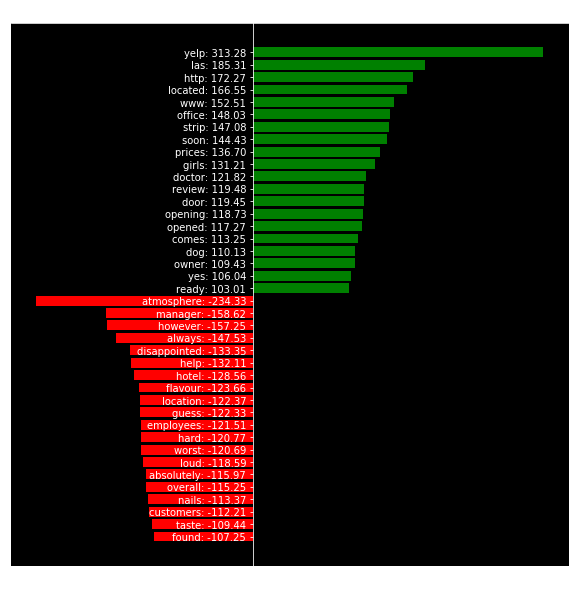

In [21]:
# baseline no reg
run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='none',
              tfidf=False,
              min_df=1,
              max_df=1.0,
              preprocessor=only_lowercase,
              binary=False
             )

size of vocabulary
6752365

train shape (479186, 6752367)
test shape (119796, 6752367)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.67      0.75      0.70    239593
     useful       0.71      0.63      0.67    239593

avg / total       0.69      0.69      0.68    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.66      0.74      0.70     59898
     useful       0.70      0.62      0.66     59898

avg / total       0.68      0.68      0.68    119796

very bad predictions


/home/dvl/anaconda3/envs/tf141/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


--------------------------------------------------------------
True Useful Votes  11
--------------------------------------------------------------

Maybe don't treat your loyal customers like crap when your food is mediocre to begin with. I've been coming here out of convenience for years, since there's only one other Thai option in the area. Went to place a phone order today and the woman taking my order was seriously annoyed with me, kept cutting me off as I was trying to tell her which items I would like (a simple lunch order, nothing complicated) and she then hung up on me as I was mid sentence. Rude! I guess you don't need the business, as I ended up getting lunch from Sa Bai instead.

--------------------------------------------------------------
True Useful Votes  10
--------------------------------------------------------------

My daughter and I went here the other day on a play date.  We have been to a lot of indoor play places lately and The Playground is an ok place.

I do

--------------------------------------------------------------
True Useful Votes  0
--------------------------------------------------------------

Pretty average food. The dog patio isn't great, it's down below by the lake and out of sight of the bar and kitchen. This translates to way less than attentive service. We had "brunch" on a slow Sunday and the service was pretty poor. Lovely setting, better concept than execution. If you're looking for good food and service, this is not your place. If you're looking for average food and unreliable service, go for it.

--------------------------------------------------------------
True Useful Votes  0
--------------------------------------------------------------

I went in on Nov. 25th to get a full set (acrylic with gel lacquer,) I usually go to Polished but I waited last minute before an event I had coming up and need to go in after normal salon business hours. For a full set I spent 75$ (with gratuity,) and two weeks later when I was rea

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l1', power_t=0.5, random_state=42, shuffle=True,
       tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

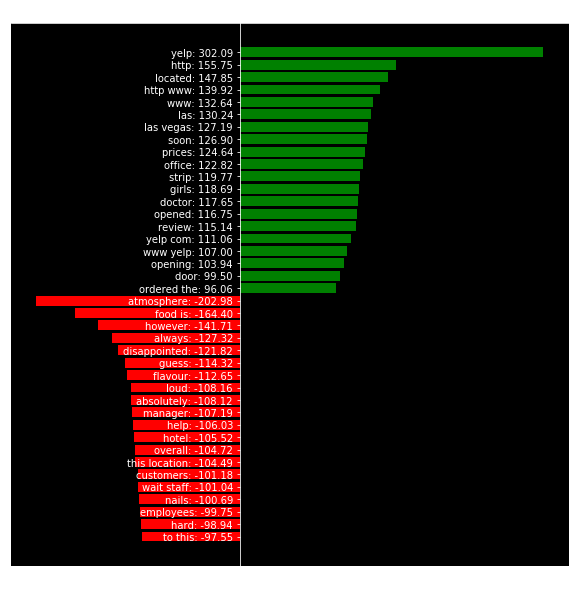

In [20]:
# baseline + bigrams + l1
run_model(stop_words=None,
              ngram_range=(1,2),
              penalty='l1',
              tfidf=False,
              min_df=1,
              max_df=1.0,
              preprocessor=only_lowercase,
              binary=False
             )

size of vocabulary
96567

train shape (479186, 96569)
test shape (119796, 96569)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.78      0.61      0.69    239593
     useful       0.68      0.83      0.75    239593

avg / total       0.73      0.72      0.72    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.78      0.61      0.68     59898
     useful       0.68      0.83      0.75     59898

avg / total       0.73      0.72      0.72    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

-------------------------------------------------------------

<Figure size 432x288 with 0 Axes>

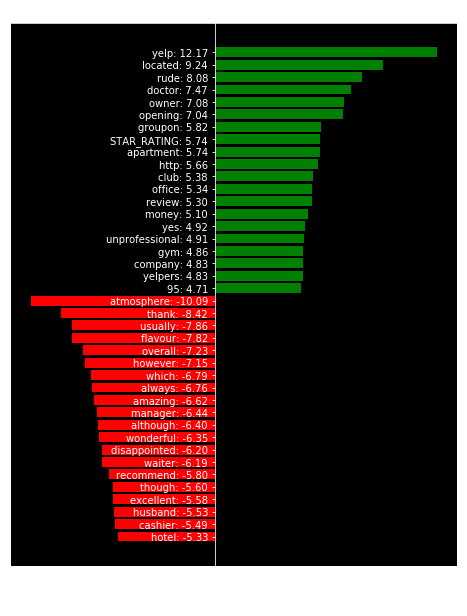

In [36]:
# basline + min_df 2
LR, vectorizer, tf_train, tf_test = run_model(
    stop_words=None,
    ngram_range=(1,1),
    penalty='l2',
    tfidf=False,
    min_df=2,
    max_df=1.0,
    preprocessor=only_lowercase,
    binary=False,
    retrieve_output=True
             )

size of vocabulary
96567

train shape (479186, 96569)
test shape (119796, 96569)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.69      0.82      0.75    239593
     useful       0.78      0.63      0.70    239593

avg / total       0.74      0.73      0.72    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.69      0.82      0.75     59898
     useful       0.78      0.63      0.69     59898

avg / total       0.73      0.72      0.72    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  11
--------------------------------------------------------------

Maybe don't treat your loyal customers like crap when your food is mediocre to begin with. I've been coming here out of convenience for years, since there's only one other Thai option in the area. Went to place a phone order today and the woman taking my order was seriously

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='elasticnet', power_t=0.5, random_state=42,
       shuffle=True, tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

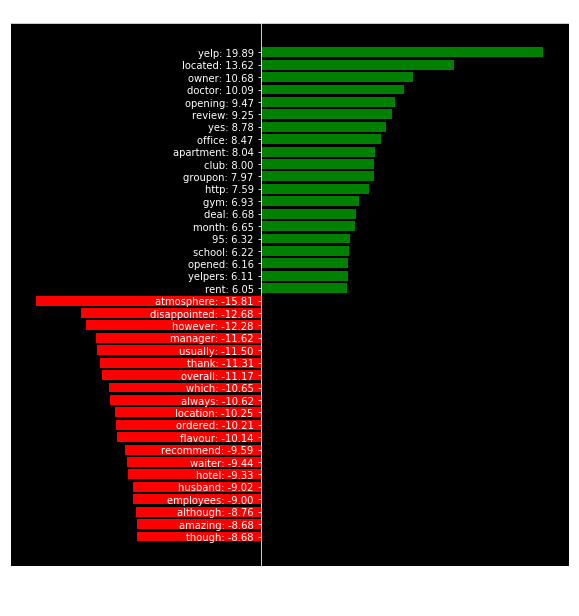

In [46]:
# basline + min_df 2 + elasticnet
run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='elasticnet',
              tfidf=False,
              min_df=2,
              max_df=1.0,
              preprocessor=only_lowercase,
              binary=False
             )

In [ ]:
# basline + min_df 2
run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='elasticnet',
              tfidf=False,
              min_df=2,
              max_df=1.0,
              preprocessor=preprocess_text,
              binary=False
             )

size of vocabulary
2433945

train shape (479186, 2433947)
test shape (119796, 2433947)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.80      0.59      0.68    239593
     useful       0.68      0.85      0.75    239593

avg / total       0.74      0.72      0.72    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.79      0.59      0.67     59898
     useful       0.67      0.85      0.75     59898

avg / total       0.73      0.72      0.71    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

-------------------------------------------------------

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

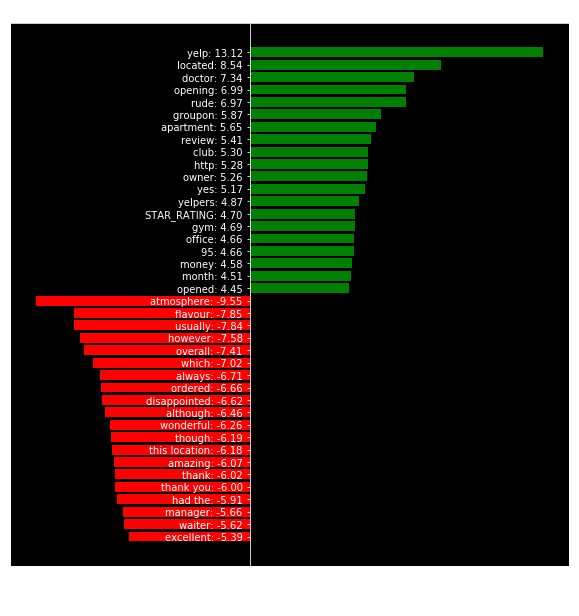

In [22]:
# baseline + bigrams + min_df 2
run_model(stop_words=None,
              ngram_range=(1,2),
              penalty='l2',
              tfidf=False,
              min_df=2,
              max_df=1.0,
              preprocessor=only_lowercase,
              binary=False
             )

size of vocabulary
2380741

train shape (479186, 2380743)
test shape (119796, 2380743)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.83      0.46      0.59    239593
     useful       0.63      0.91      0.74    239593

avg / total       0.73      0.68      0.67    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.83      0.45      0.59     59898
     useful       0.62      0.90      0.74     59898

avg / total       0.72      0.68      0.66    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

-------------------------------------------------------

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

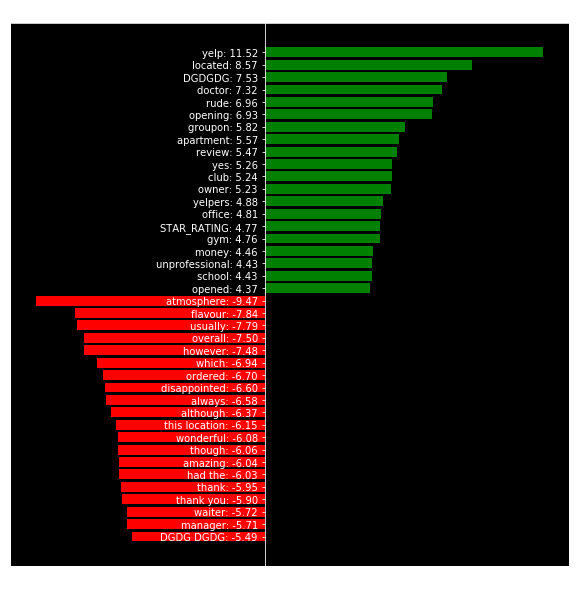

In [23]:
# baseline + preprocess + mind_df2 + bigrams
run_model(stop_words=None,
              ngram_range=(1,2),
              penalty='l2',
              tfidf=False,
              min_df=2,
              max_df=1.0,
              preprocessor=preprocess_text,
              binary=False
             )

size of vocabulary
91918

train shape (479186, 91920)
test shape (119796, 91920)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.80      0.57      0.67    239593
     useful       0.67      0.86      0.75    239593

avg / total       0.73      0.71      0.71    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.80      0.57      0.66     59898
     useful       0.67      0.85      0.75     59898

avg / total       0.73      0.71      0.71    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

-------------------------------------------------------------

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

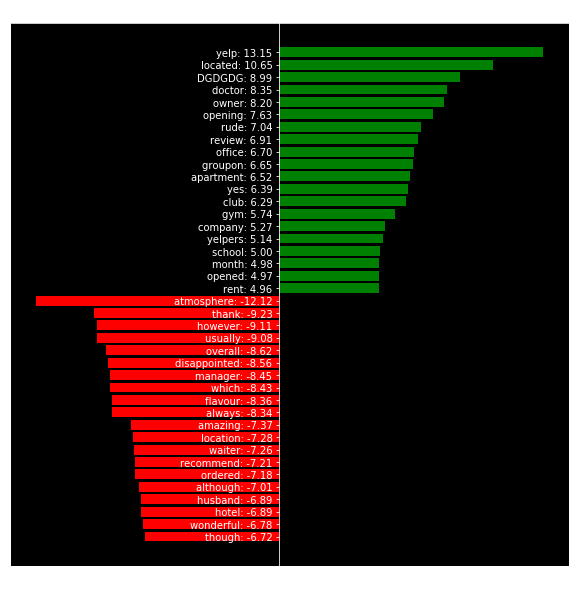

In [26]:
# basline + min_df 2 + preprocess
run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='l2',
              tfidf=False,
              min_df=2,
              max_df=1.0,
              preprocessor=preprocess_text,
              binary=False
             )

size of vocabulary
132298

train shape (479186, 132300)
test shape (119796, 132300)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.80      0.55      0.65    239593
     useful       0.66      0.86      0.75    239593

avg / total       0.73      0.71      0.70    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.80      0.55      0.65     59898
     useful       0.66      0.86      0.75     59898

avg / total       0.73      0.71      0.70    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

----------------------------------------------------------

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

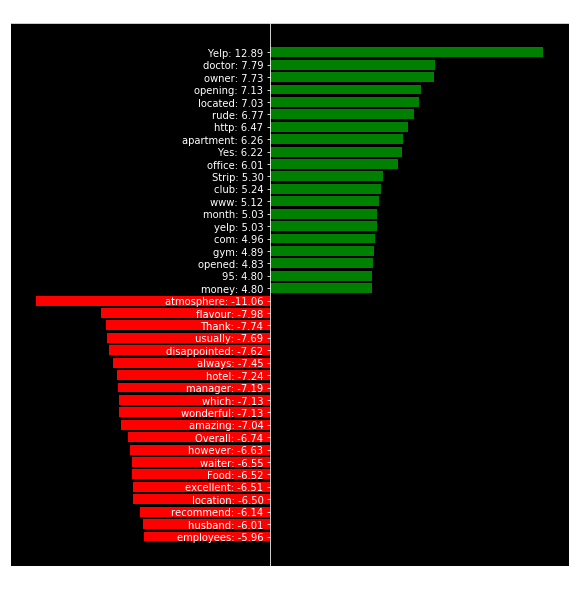

In [44]:
# basline + min_df 2 + preprocess
run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='l2',
              tfidf=False,
              min_df=2,
              max_df=1.0,
              preprocessor=None,
              binary=False
             )

size of vocabulary
8100702

train shape (479186, 8100704)
test shape (119796, 8100704)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.67      0.73      0.70    239593
     useful       0.71      0.64      0.67    239593

avg / total       0.69      0.69      0.69    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.67      0.73      0.70     59898
     useful       0.70      0.64      0.67     59898

avg / total       0.68      0.68      0.68    119796

very bad predictions


/home/dvl/anaconda3/envs/tf141/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


--------------------------------------------------------------
True Useful Votes  11
--------------------------------------------------------------

Maybe don't treat your loyal customers like crap when your food is mediocre to begin with. I've been coming here out of convenience for years, since there's only one other Thai option in the area. Went to place a phone order today and the woman taking my order was seriously annoyed with me, kept cutting me off as I was trying to tell her which items I would like (a simple lunch order, nothing complicated) and she then hung up on me as I was mid sentence. Rude! I guess you don't need the business, as I ended up getting lunch from Sa Bai instead.

--------------------------------------------------------------
True Useful Votes  22
--------------------------------------------------------------

These guys are awesome. Went there to have my brakes checked thought I needed new pads. Turns out they did not need new pads just to be cleaned and lu

--------------------------------------------------------------
True Useful Votes  0
--------------------------------------------------------------

I went in on Nov. 25th to get a full set (acrylic with gel lacquer,) I usually go to Polished but I waited last minute before an event I had coming up and need to go in after normal salon business hours. For a full set I spent 75$ (with gratuity,) and two weeks later when I was ready for a fill every single nail was lifting off! The technician at Polished said he hadn't seen that level of poor application in his whole career! I called Get Nailed 24/7 to let them know I was unhappy with my service, and the person who answered the phone took my name and phone number and said a manager would call me. Well the manager NEVER called! In short, save your money and go to a reputable salon that cares about the level of service they perform.

--------------------------------------------------------------
True Useful Votes  0
-------------------------

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l1', power_t=0.5, random_state=42, shuffle=True,
       tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

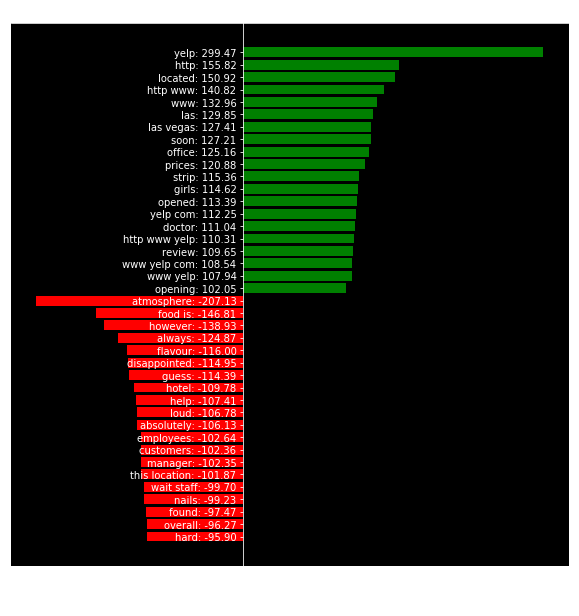

In [45]:
# baseline + bigrams + trigrams + l1
run_model(stop_words=None,
              ngram_range=(1,3),
              penalty='l1',
              tfidf=False,
              min_df=2,
              max_df=1.0,
              preprocessor=only_lowercase,
              binary=False
             )

# Coefs of best LR




In [ ]:
# basline + min_df 2
LR, vectorizer, tf_train, tf_test = run_model(
    stop_words=None,
    ngram_range=(1,1),
    penalty='l2',
    tfidf=False,
    min_df=2,
    max_df=1.0,
    preprocessor=only_lowercase,
    binary=False,
    retrieve_output=True
             )
feature_names = np.array(vectorizer.get_feature_names())

<Figure size 432x288 with 0 Axes>

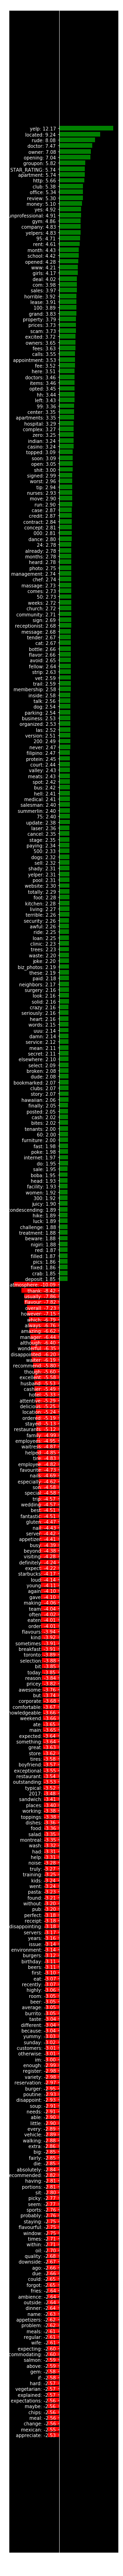

In [34]:
plot_LR_important_features(LR,vectorizer,num_features=200,size=[4.2,100])

In [61]:
tf_test.shape

(119796, 96569)

In [72]:
np.where(np.array(tf_test.tocsr()[
    :,np.where(np.isin(feature_names,text_to_find))[0][0]
].todense()) > 0 )[0][0]

22

In [95]:
text_to_find=['yelper']
n_examples = 30
# columns of text of interest
for index, row in X_test.iloc[np.where(np.array(tf_test.tocsr()[
    :,np.where(np.isin(feature_names,text_to_find))[0][0]
].todense()) > 0 )[0][:n_examples]].iterrows():
    print("Useful Votes: ",row.useful)
    print(row.text)
    print("----------------------------------------------------")
    print("----------------------------------------------------")
    print("----------------------------------------------------")




Useful Votes:  15
I am a fan of the casino cafe (or Diner as they call them in New York). Sadly, the casinos are gradually replacing them with newer restaurants. In downtown Las Vegas, we recently lost the El Cortez Cafe to Pizza Lotto and the Golden Nugget Cafe to Claim Jumper. I believe that the old school casino cafes compliment the casino experience along with good food at reasonable prices. And so, when I met up with my brother on the Fremont Street East District, we'd walk to the Cali where I'd take advantage of some good old school cafe food. 

    The Market Street Cafe is both the Cali cafe and a restaurant serving Hawaiian food. Their oxtail soup has become a Las Vegas legend. This is no accident. The Cali caters to the Hawaii market and is the epicenter of the Ninth Island casino scene. Market Street Cafe also features a diverse menu with a range of reasonably priced comfort food and daily specials. I usually order the $9.99 prime rib special. This includes the soup and sala

#### More models

size of vocabulary
175939

train shape (479186, 175941)
test shape (119796, 175941)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.83      0.30      0.44    239593
     useful       0.57      0.94      0.71    239593

avg / total       0.70      0.62      0.58    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.82      0.30      0.44     59898
     useful       0.57      0.94      0.71     59898

avg / total       0.70      0.62      0.57    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

----------------------------------------------------------

<Figure size 432x288 with 0 Axes>

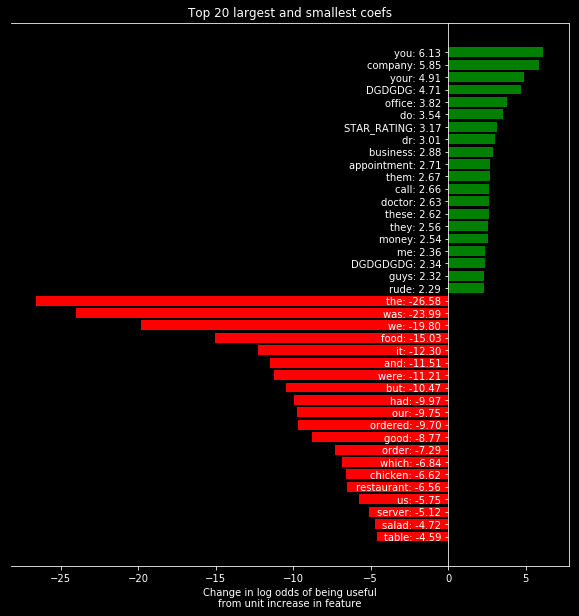

In [129]:
run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='l2',
              tfidf=True,
              min_df=1,
              preprocessor=preprocess_text,
              binary=True
             )

size of vocabulary
175627

train shape (479186, 175629)
test shape (119796, 175629)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.83      0.30      0.44    239593
     useful       0.57      0.94      0.71    239593

avg / total       0.70      0.62      0.57    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.82      0.30      0.43     59898
     useful       0.57      0.94      0.71     59898

avg / total       0.70      0.62      0.57    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

----------------------------------------------------------

<Figure size 432x288 with 0 Axes>

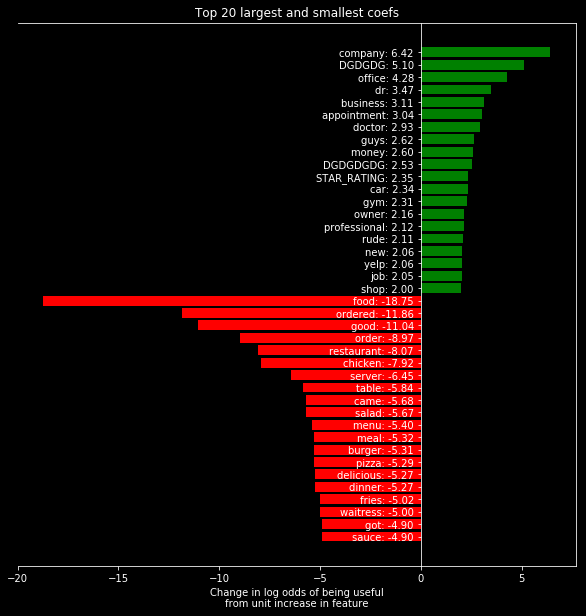

In [130]:
run_model(stop_words='english',
              ngram_range=(1,1),
              penalty='l2',
              tfidf=True,
              min_df=1,
              preprocessor=preprocess_text,
              binary=False
             )

size of vocabulary
175627

train shape (479186, 175629)
test shape (119796, 175629)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.73      0.70      0.72    239593
     useful       0.71      0.74      0.73    239593

avg / total       0.72      0.72      0.72    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.73      0.71      0.72     59898
     useful       0.71      0.74      0.73     59898

avg / total       0.72      0.72      0.72    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  11
--------------------------------------------------------------

Maybe don't treat your loyal customers like crap when your food is mediocre to begin with. I've been coming here out of convenience for years, since there's only one other Thai option in the area. Went to place a phone order today and the woman taking my order was seriou

<Figure size 432x288 with 0 Axes>

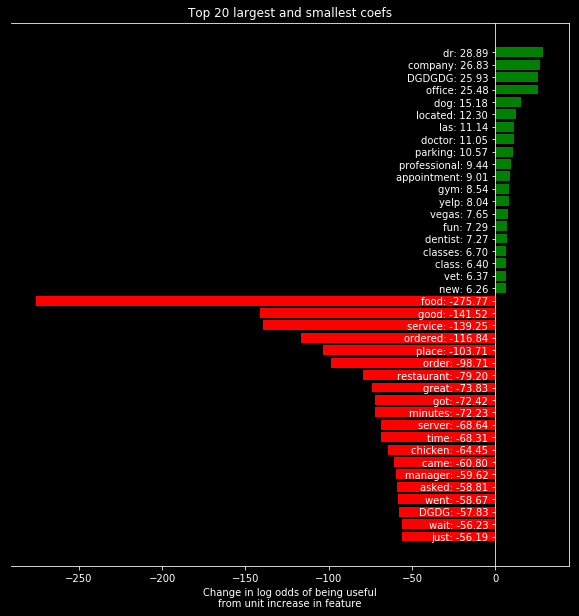

In [131]:
run_model(stop_words='english',
              ngram_range=(1,1),
              penalty='l1',
              tfidf=True,
              min_df=1,
              preprocessor=preprocess_text,
              binary=False
             )

size of vocabulary
175627

train shape (479186, 175629)
test shape (119796, 175629)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.80      0.53      0.64    239593
     useful       0.65      0.87      0.74    239593

avg / total       0.73      0.70      0.69    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.80      0.53      0.64     59898
     useful       0.65      0.86      0.74     59898

avg / total       0.72      0.70      0.69    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

----------------------------------------------------------

<Figure size 432x288 with 0 Axes>

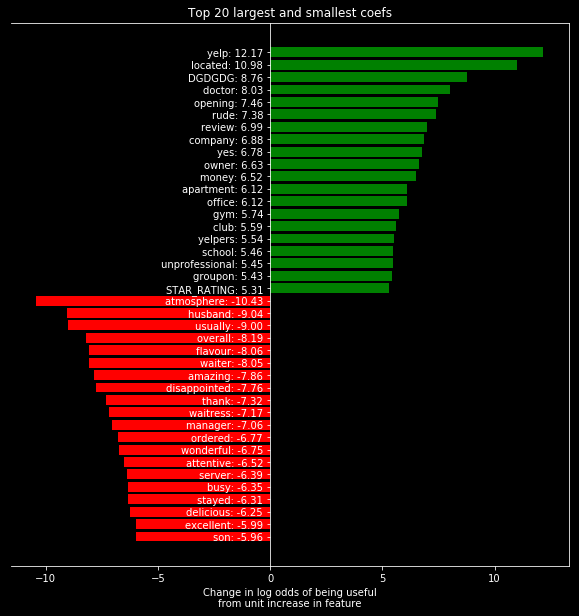

In [132]:
run_model(stop_words='english',
              ngram_range=(1,1),
              penalty='l2',
              tfidf=False,
              min_df=1,
              preprocessor=preprocess_text,
              binary=False
             )

size of vocabulary
91607

train shape (479186, 91609)
test shape (119796, 91609)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.78      0.49      0.60    239593
     useful       0.63      0.86      0.73    239593

avg / total       0.70      0.68      0.66    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.78      0.50      0.61     59898
     useful       0.63      0.86      0.73     59898

avg / total       0.70      0.68      0.67    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

-------------------------------------------------------------

<Figure size 432x288 with 0 Axes>

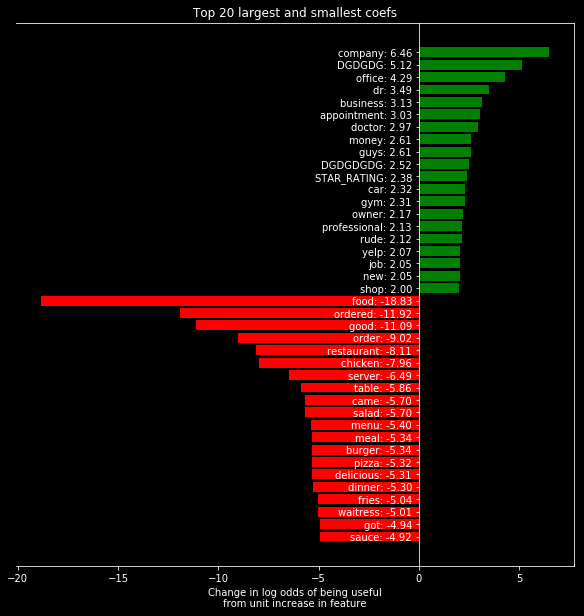

In [133]:
run_model(stop_words='english',
              ngram_range=(1,1),
              penalty='l2',
              tfidf=True,
              min_df=2,
              preprocessor=preprocess_text,
              binary=False
             )

size of vocabulary
195497

train shape (479186, 195499)
test shape (119796, 195499)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.80      0.56      0.66    239593
     useful       0.66      0.86      0.75    239593

avg / total       0.73      0.71      0.70    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.79      0.56      0.66     59898
     useful       0.66      0.85      0.75     59898

avg / total       0.73      0.71      0.70    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

----------------------------------------------------------

<Figure size 432x288 with 0 Axes>

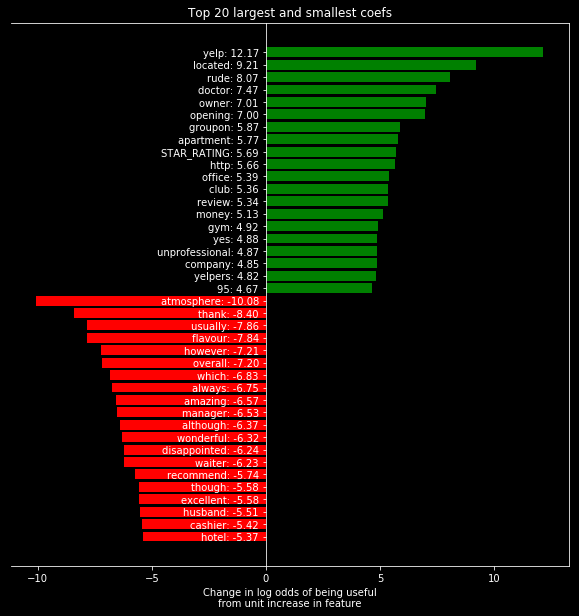

In [140]:
run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='l2',
              tfidf=False,
              min_df=1,
              preprocessor=only_lowercase,
              binary=False
             )

size of vocabulary
195185

train shape (479186, 195187)
test shape (119796, 195187)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.83      0.44      0.58    239593
     useful       0.62      0.91      0.74    239593

avg / total       0.72      0.67      0.66    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.82      0.44      0.57     59898
     useful       0.62      0.90      0.73     59898

avg / total       0.72      0.67      0.65    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

----------------------------------------------------------

<Figure size 432x288 with 0 Axes>

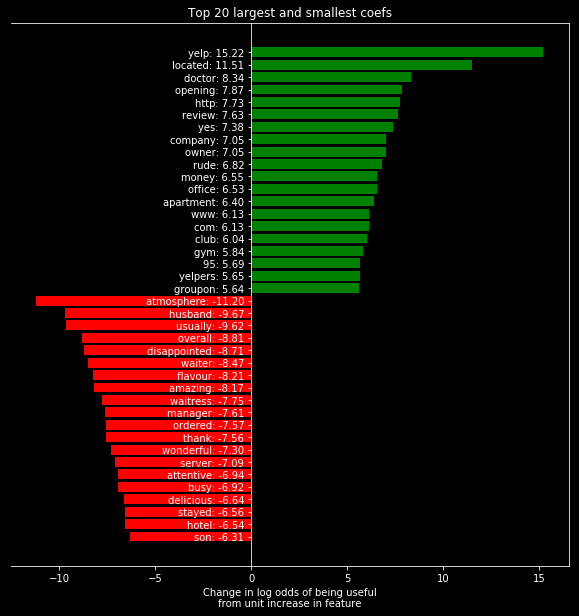

In [134]:
run_model(stop_words='english',
              ngram_range=(1,1),
              penalty='l2',
              tfidf=False,
              min_df=1,
              preprocessor=only_lowercase,
              binary=False
             )

size of vocabulary
195185

train shape (479186, 195187)
test shape (119796, 195187)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.79      0.55      0.65    239593
     useful       0.66      0.86      0.74    239593

avg / total       0.73      0.70      0.70    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.79      0.55      0.65     59898
     useful       0.66      0.85      0.74     59898

avg / total       0.72      0.70      0.70    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  22
--------------------------------------------------------------

These guys are awesome. Went there to have my brakes checked thought I needed new pads. Turns out they did not need new pads just to be cleaned and lubricated. They inspected the brakes and showed me what was wrong before fixing them. I ended paying much less because I d

<Figure size 432x288 with 0 Axes>

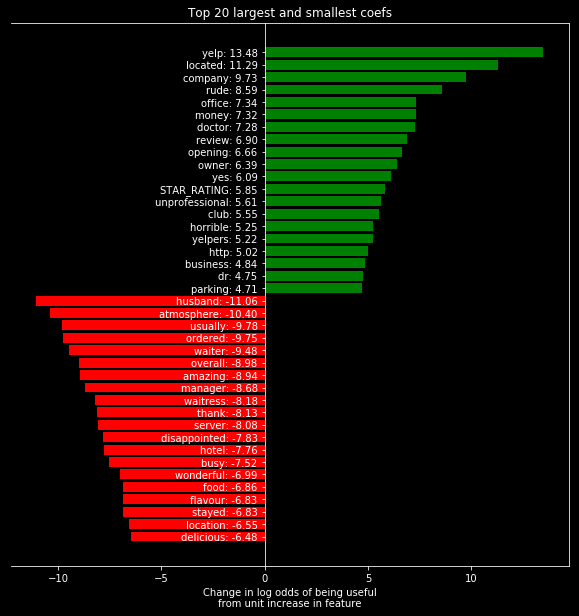

In [135]:

run_model(stop_words='english',
              ngram_range=(1,1),
              penalty='l2',
              tfidf=False,
              min_df=1,
              preprocessor=only_lowercase,
              binary=True
             )

size of vocabulary
195185

train shape (479186, 195187)
test shape (119796, 195187)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.64      0.86      0.73    239593
     useful       0.79      0.52      0.63    239593

avg / total       0.71      0.69      0.68    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.64      0.86      0.74     59898
     useful       0.79      0.52      0.63     59898

avg / total       0.72      0.69      0.68    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  11
--------------------------------------------------------------

Maybe don't treat your loyal customers like crap when your food is mediocre to begin with. I've been coming here out of convenience for years, since there's only one other Thai option in the area. Went to place a phone order today and the woman taking my order was seriou

<Figure size 432x288 with 0 Axes>

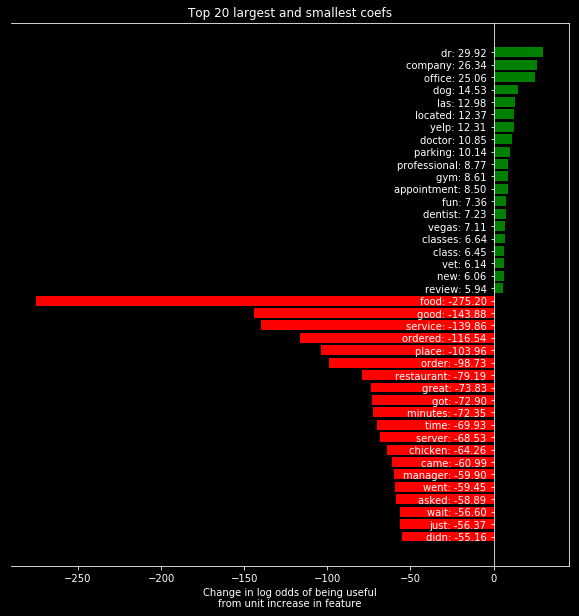

In [137]:
run_model(stop_words='english',
              ngram_range=(1,1),
              penalty='l1',
              tfidf=True,
              min_df=1,
              preprocessor=only_lowercase,
              binary=False
             )

size of vocabulary
195497

train shape (479186, 195499)
test shape (119796, 195499)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.63      0.84      0.72    239593
     useful       0.76      0.51      0.61    239593

avg / total       0.70      0.68      0.67    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.63      0.84      0.72     59898
     useful       0.77      0.51      0.61     59898

avg / total       0.70      0.68      0.67    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  10
--------------------------------------------------------------

TOtal scam company from top to bottom. They will lure you in with promotions and discounts and then not honor them. When you call them afterwards they will give you the run around and eventually not return your call.  Look closely, they use different names for their comp

--------------------------------------------------------------
True Useful Votes  0
--------------------------------------------------------------

With 4 vehicles in our family, we have had a long relationship with SD. Overall, Mike and his team have always taken excellent care of us and the cars. We have never had any breakdowns on the road since in their care. I would recommend to family and friends. From time to time, they have even gone above and beyond normal service by investigating a few mysterious issues with our vehicles, even doing so without charging us for their time.

I would give them 5 stars, but they have made a few mistakes along the way, including one serious, neglectful error, that could have caused devastating damage to my work van had I not noticed the loose lug nuts on my rear wheel upon getting it home. We worked through the issue after Mike had a very sincere conversation with my wife. My suggestion for their team is tighten up on the details, like topping off 

<Figure size 432x288 with 0 Axes>

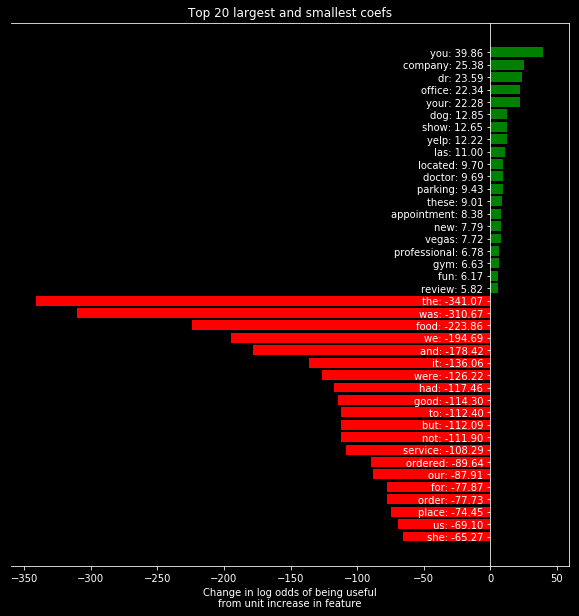

In [138]:
run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='l1',
              tfidf=True,
              min_df=1,
              preprocessor=only_lowercase,
              binary=False
             )

size of vocabulary
195497

train shape (479186, 195499)
test shape (119796, 195499)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.69      0.69      0.69    239593
     useful       0.69      0.69      0.69    239593

avg / total       0.69      0.69      0.69    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.68      0.69      0.69     59898
     useful       0.69      0.68      0.68     59898

avg / total       0.69      0.69      0.69    119796

very bad predictions


/home/dvl/anaconda3/envs/tf141/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


--------------------------------------------------------------
True Useful Votes  11
--------------------------------------------------------------

Maybe don't treat your loyal customers like crap when your food is mediocre to begin with. I've been coming here out of convenience for years, since there's only one other Thai option in the area. Went to place a phone order today and the woman taking my order was seriously annoyed with me, kept cutting me off as I was trying to tell her which items I would like (a simple lunch order, nothing complicated) and she then hung up on me as I was mid sentence. Rude! I guess you don't need the business, as I ended up getting lunch from Sa Bai instead.

--------------------------------------------------------------
True Useful Votes  10
--------------------------------------------------------------

My daughter and I went here the other day on a play date.  We have been to a lot of indoor play places lately and The Playground is an ok place.

I do

--------------------------------------------------------------
True Useful Votes  0
--------------------------------------------------------------

Pretty average food. The dog patio isn't great, it's down below by the lake and out of sight of the bar and kitchen. This translates to way less than attentive service. We had "brunch" on a slow Sunday and the service was pretty poor. Lovely setting, better concept than execution. If you're looking for good food and service, this is not your place. If you're looking for average food and unreliable service, go for it.

--------------------------------------------------------------
True Useful Votes  0
--------------------------------------------------------------

First time in this spot with my spouse  and loved the classic dinner setting.the staff were super welcoming and friendly. Never got the chance to try the other items on the menu but had the chili cheese fries. As you can tell, everyone including me are suckers for their chili chees

<Figure size 432x288 with 0 Axes>

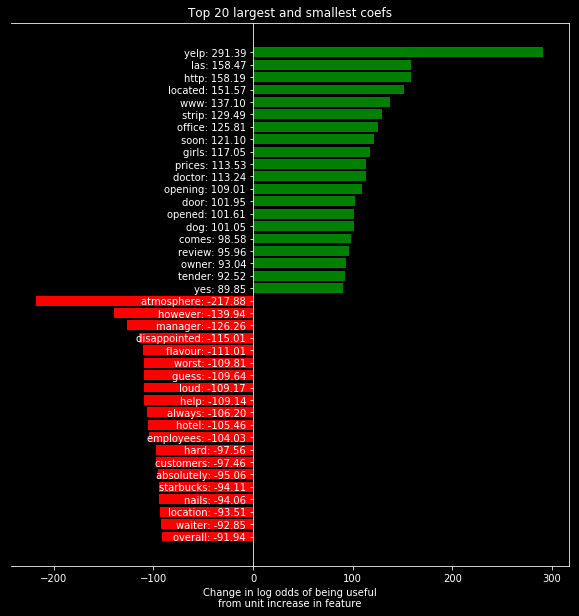

In [141]:
run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='l1',
              tfidf=False,
              min_df=1,
              preprocessor=only_lowercase,
              binary=False
             )

size of vocabulary
96567

train shape (479186, 96569)
test shape (119796, 96569)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.78      0.61      0.69    239593
     useful       0.68      0.83      0.75    239593

avg / total       0.73      0.72      0.72    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.78      0.61      0.68     59898
     useful       0.68      0.83      0.75     59898

avg / total       0.73      0.72      0.72    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

-------------------------------------------------------------

<Figure size 432x288 with 0 Axes>

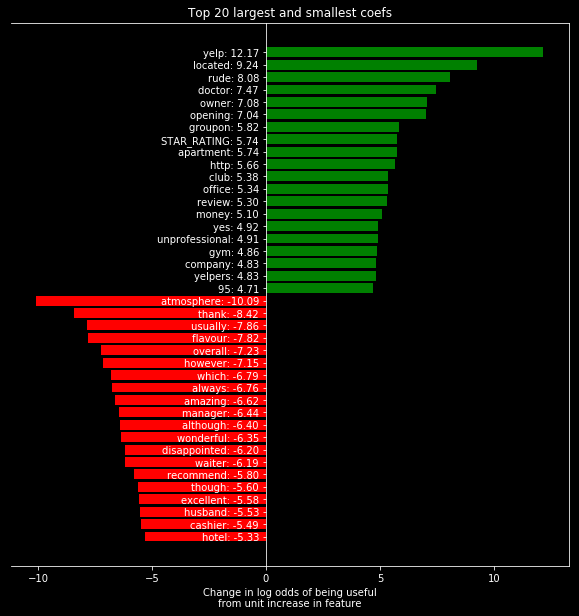

In [142]:
run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='l2',
              tfidf=False,
              min_df=2,
              preprocessor=only_lowercase,
              binary=False
             )

size of vocabulary
91918

train shape (479186, 91920)
test shape (119796, 91920)
result on training set:
             precision    recall  f1-score   support

 not_useful       0.80      0.57      0.67    239593
     useful       0.67      0.86      0.75    239593

avg / total       0.73      0.71      0.71    479186


result on test set:
             precision    recall  f1-score   support

 not_useful       0.80      0.57      0.66     59898
     useful       0.67      0.85      0.75     59898

avg / total       0.73      0.71      0.71    119796

very bad predictions
--------------------------------------------------------------
True Useful Votes  19
--------------------------------------------------------------

OMG. What a horrible rude douche that answered the phone. I didn't even get passed that, much less order a pizza. Why is this place still in biz? No customer service whatsoever. I'd rather go to Little Caesar's.

-------------------------------------------------------------

<Figure size 432x288 with 0 Axes>

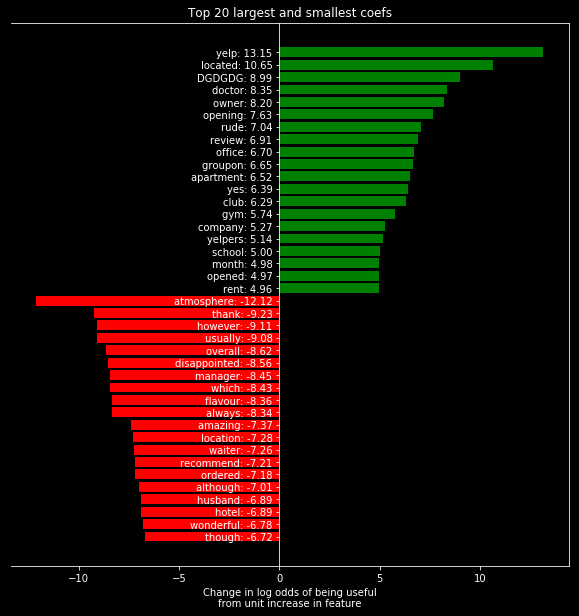

In [143]:
run_model(stop_words=None,
              ngram_range=(1,1),
              penalty='l2',
              tfidf=False,
              min_df=2,
              preprocessor=preprocess_text,
              binary=False
             )

In [ ]:
run_model(stop_words='english',
              ngram_range=(1,2),
              penalty='l2',
              tfidf=False,
              min_df=2,
              preprocessor=preprocess_text,
              binary=False
             )